<h1>ResNext 50 Convolutional Neural Network</h1>

![Descripción de la imagen](./assets/images/Architecture%20ResNext50.png)


In [ ]:
# Importation of libraries
import os
import csv
import numpy as np
from keras.layers import Input, Add, Activation, ZeroPadding2D, BatchNormalization, Conv2D, MaxPooling2D,UpSampling2D,Softmax,Concatenate
from keras.models import Model, load_model
from keras.utils import to_categorical
import tensorflow as tf
from PIL import Image
import math
from math import pi
from math import cos
from math import floor
from keras.initializers import glorot_uniform
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import LearningRateScheduler

In [ ]:
#Clean the environment before starting a new workout
tf.keras.backend.clear_session()

In [ ]:
print("Number of GPUs enabled:", len(tf.config.experimental.list_physical_devices('GPU')))

In [ ]:
# Directory of images and masks
training_images='./dataset/train/images/'
training_masks='./dataset/train/masks/'
validation_images='./dataset/val/images/'
validation_masks='./dataset/val/masks/'
labels_data='./dataset/_classes.csv'

In [ ]:
# Definition of hyperparameters
epochsNumber=25
imageWidth=128
imageHeigth=128
imageWidthInput=128
imageHeigthInput=128
batchSize=2
learningRatee=0.01

In [ ]:
# List of classes
def listaClases():
    listClasses=[]
    
    with open(labels_data, 'r') as csvfile:
        csvreader = csv.reader(csvfile)
        for row in csvreader:
            class_value = row[1].strip()
            listClasses.append(class_value)
        listClasses.pop(0)
        
    return listClasses

classesNumber=len(listaClases())

In [ ]:
# Load masks
def loadMask(mask_names,directory_name):
    mask_list = []
    for i in mask_names:
        mask_array = np.array(Image.open(
            directory_name+i), dtype=np.uint8)
        mask_list.append(to_categorical(
            mask_array, num_classes=classesNumber))
    return np.array(mask_list)

In [ ]:
# Load image
def read_image_RGB(directory_name, file_name):
    img = Image.open(directory_name + file_name)
    img_rgb = img.convert("RGB")
    return img_rgb

In [ ]:
# Method to create a numpy array of the dataset images
def loadImages(directory_name,images_name):
    array_images = np.zeros((len(images_name), imageHeigth, imageWidth,3), dtype=np.uint8)
    i=0
    for image_name in images_name:
        array_images[i,:] = read_image_RGB(directory_name,image_name)
        i=i+1
    return array_images

In [ ]:
# Method for creating arrays of training and testing data
def data_train():
    training_image_names = sorted([str(i) for i in os.listdir(training_images)])
    training_mask_names = sorted([str(i) for i in os.listdir(training_masks)])
    
    validation_image_names = sorted([str(i) for i in os.listdir(validation_images)])
    validation_mask_names = sorted([str(i) for i in os.listdir(validation_masks)])

    X_train = loadImages(training_images, training_image_names)
    Y_train = loadMask(training_mask_names, training_masks)

    X_validation = loadImages(validation_images, validation_image_names)
    Y_validation = loadMask(validation_mask_names, validation_masks)

    X_train = X_train/255
    X_validation = X_validation/255

    return X_train.astype(np.float32), Y_train.astype(np.uint8), X_validation.astype(np.float32), Y_validation.astype(np.uint8)

In [ ]:
X_train, Y_train, X_validation, Y_validation = data_train()

In [ ]:
# Construction of the identity block
def identity_block(X, f, filters, stage, block):
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value. We'll need this later to add back to the main path. 
    X_shortcut = X
    
    ###### Construction paths of ResNeXt (ResNeXt 50 cardinality 2) 
    
    X_out=X
    
    # Cardinality 2
    for i in range(2):
        
        # First component of main path
        X_split = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a'+str(i+1)+'_'+str(F1)+'_1x1', kernel_initializer = glorot_uniform(seed=0))(X)
        X_split = BatchNormalization(axis = 3, name = bn_name_base + '2a'+str(i+1))(X_split)
        X_split = Activation('mish')(X_split)
    
        
        # Second component of main path
        X_split = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b'+str(i+1)+'_'+str(F2)+'_3x3', kernel_initializer = glorot_uniform(seed=0))(X_split)
        X_split = BatchNormalization(axis = 3, name = bn_name_base + '2b'+str(i+1))(X_split)
        X_split = Activation('mish')(X_split)
    
      
        if i==0:
            X_out = X_split
        else:
            X_out = Concatenate(axis=-1)([X_out,X_split])

    # Third component of main path
    X_out = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c'+'_'+str(F3)+'_1x1', kernel_initializer = glorot_uniform(seed=0))(X_out)
    X_out = BatchNormalization(axis = 3, name = bn_name_base + '2c'+str(i+1))(X_out)

            
    # Final step: Add shortcut value to main path, and pass it through a mish activation
    X = Add()([X_shortcut,X_out])
    X = Activation('mish')(X)

    return X

In [ ]:
# Construction of the convolutional block
def convolutional_block(X, f, filters, stage, block, s = 2):
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X
    
    ###### Construction paths of ResNeXt (ResNeXt 50 cardinality 2) 
    
    X_out=X
    
    # Cardinality 2
    for i in range(2):

        ##### MAIN PATH #####
        # First component of main path 
        X_split = Conv2D(filters=F1, kernel_size=(1, 1), strides = (s,s), padding='valid', name = conv_name_base + '2a'+str(i+1)+'_'+str(F1)+'_1x1', kernel_initializer = glorot_uniform(seed=0))(X)
        X_split = BatchNormalization(axis = 3, name = bn_name_base + '2a'+str(i+1))(X_split)
        X_split = Activation('mish')(X_split)

        # Second component of main path
        X_split = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b'+str(i+1)+'_'+str(F2)+'_3x3', kernel_initializer=glorot_uniform(seed=0))(X_split)
        X_split = BatchNormalization(axis=3, name=bn_name_base + '2b'+str(i+1))(X_split)
        X_split = Activation('mish')(X_split)


        if i==0:
            X_out = X_split
        else:
            X_out = Concatenate(axis=-1)([X_out,X_split])
            
    # Third component of main path
    X_out = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c'+str(i+1)+'_'+str(F3)+'_1x1', kernel_initializer=glorot_uniform(seed=0))(X_out)
    X_out = BatchNormalization(axis=3, name=bn_name_base + '2c'+str(i+1))(X_out)

    ##### SHORTCUT PATH ####
    X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides = (s,s), padding='valid', name = conv_name_base + '1', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a mish activation
    X = Add()([X_shortcut,X_out])
    X = Activation('mish')(X)
    
    return X

In [ ]:
def ResNeXt50(input_shape, classes):   
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)
    
    ######## ENCODER #######
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('mish')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [40, 40, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [40, 40, 256], stage=2, block='b')
    X = identity_block(X, 3, [40, 40, 256], stage=2, block='c')
   

    # Stage 3
    X = convolutional_block(X, f = 3, filters = [80, 80, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [80, 80, 512], stage=3, block='b')
    X = identity_block(X, 3, [80, 80, 512], stage=3, block='c')
    X = identity_block(X, 3, [80, 80, 512], stage=3, block='d')
    
    ###################
    X_upsampling3 = UpSampling2D(size=(2, 2))(X)
    
    X_upsampling3 = Conv2D(256, (3, 3), padding='same', strides = (1, 1), name = 'upsampling31', kernel_initializer = glorot_uniform(seed=0))(X_upsampling3)
    X_upsampling3 = BatchNormalization(axis = 3, name = 'bn_upsampling31')(X_upsampling3)
    X_upsampling3 = Activation('mish')(X_upsampling3)
    
    X_upsampling3 = identity_block(X_upsampling3, 3, [40, 40, 256], stage=3, block='up_a')
    
    ###################
    X_upsampling3 = UpSampling2D(size=(2, 2))(X_upsampling3)

    X_upsampling3 = Conv2D(128, (3, 3), padding='same', strides = (1, 1), name = 'upsampling32', kernel_initializer = glorot_uniform(seed=0))(X_upsampling3)
    X_upsampling3 = BatchNormalization(axis = 3, name = 'bn_upsampling32')(X_upsampling3)
    X_upsampling3 = Activation('mish')(X_upsampling3)
    
    X_upsampling3 = identity_block(X_upsampling3, 3, [20, 20, 128], stage=3, block='up_b')

    ###################
    X_upsampling3 = UpSampling2D(size=(2, 2))(X_upsampling3)

    X_upsampling3 = Conv2D(32, (3, 3), padding='same', strides = (1, 1), name = 'upsampling33', kernel_initializer = glorot_uniform(seed=0))(X_upsampling3)
    X_upsampling3 = BatchNormalization(axis = 3, name = 'bn_upsampling33')(X_upsampling3)
    X_upsampling3 = Activation('mish')(X_upsampling3)

    X_upsampling3 = Conv2D(classes, (1, 1), padding='same', strides = (1, 1), name = 'upsampling34', kernel_initializer = glorot_uniform(seed=0))(X_upsampling3)
    X_upsampling3 = BatchNormalization(axis = 3, name = 'bn_upsampling34')(X_upsampling3)


    # Stage 4
    X = convolutional_block(X, f = 3, filters = [160, 160, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [160, 160, 1024], stage=4, block='b')
    X = identity_block(X, 3, [160, 160, 1024], stage=4, block='c')
    X = identity_block(X, 3, [160, 160, 1024], stage=4, block='d')
    X = identity_block(X, 3, [160, 160, 1024], stage=4, block='e')
    X = identity_block(X, 3, [160, 160, 1024], stage=4, block='f')
    
    ###################
    X_upsampling4 = UpSampling2D(size=(2, 2))(X) 
    
    X_upsampling4 = Conv2D(512, (3, 3), padding='same', strides = (1, 1), name = 'upsampling41', kernel_initializer = glorot_uniform(seed=0))(X_upsampling4)
    X_upsampling4 = BatchNormalization(axis = 3, name = 'bn_upsampling41')(X_upsampling4)
    X_upsampling4 = Activation('mish')(X_upsampling4)

    X_upsampling4 = identity_block(X_upsampling4, 3, [80, 80, 512], stage=4, block='up_a')
    
    ###################
    X_upsampling4 = UpSampling2D(size=(2, 2))(X_upsampling4)
    
    X_upsampling4 = Conv2D(256, (3, 3), padding='same', strides = (1, 1), name = 'upsampling42', kernel_initializer = glorot_uniform(seed=0))(X_upsampling4)
    X_upsampling4 = BatchNormalization(axis = 3, name = 'bn_upsampling42')(X_upsampling4)
    X_upsampling4 = Activation('mish')(X_upsampling4)

    X_upsampling4 = identity_block(X_upsampling4, 3, [40, 40, 256], stage=4, block='up_b')

    ###################
    X_upsampling4 = UpSampling2D(size=(2, 2))(X_upsampling4)
    X_upsampling4 = Conv2D(128, (3, 3), padding='same', strides = (1, 1), name = 'upsampling43', kernel_initializer = glorot_uniform(seed=0))(X_upsampling4)
    X_upsampling4 = BatchNormalization(axis = 3, name = 'bn_upsampling43')(X_upsampling4)
    X_upsampling4 = Activation('mish')(X_upsampling4)
    
    X_upsampling4 = identity_block(X_upsampling4, 3, [20, 20, 128], stage=4, block='up_c')

    ###################
    X_upsampling4 = UpSampling2D(size=(2, 2))(X_upsampling4)
    
    X_upsampling4 = Conv2D(32, (3, 3), padding='same', strides = (1, 1), name = 'upsampling44', kernel_initializer = glorot_uniform(seed=0))(X_upsampling4)
    X_upsampling4 = BatchNormalization(axis = 3, name = 'bn_upsampling44')(X_upsampling4)
    X_upsampling4 = Activation('mish')(X_upsampling4)
    
    X_upsampling4 = Conv2D(classes, (1, 1), padding='same', strides = (1, 1), name = 'upsampling45', kernel_initializer = glorot_uniform(seed=0))(X_upsampling4)
    X_upsampling4 = BatchNormalization(axis = 3, name = 'bn_upsampling45')(X_upsampling4)

    
    
    # Stage 5
    X = convolutional_block(X, f = 3, filters = [320, 320, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [320, 320, 2048], stage=5, block='b')
    X = identity_block(X, 3, [320, 320, 2048], stage=5, block='c')
    
    ###################
    X_upsampling5 = UpSampling2D(size=(2, 2))(X)
    
    X_upsampling5 = Conv2D(1024, (3, 3), padding='same',  strides = (1, 1), name = 'upsampling51', kernel_initializer = glorot_uniform(seed=0))(X_upsampling5)
    X_upsampling5 = BatchNormalization(axis = 3, name = 'bn_upsampling51')(X_upsampling5)
    X_upsampling5 = Activation('mish')(X_upsampling5)

    X_upsampling5 = identity_block(X_upsampling5, 3, [160, 160, 1024], stage=5, block='up_a')

       
    ###################
    X_upsampling5 = UpSampling2D(size=(2, 2))(X_upsampling5)
    
    X_upsampling5 = Conv2D(512, (3, 3), padding='same',  strides = (1, 1), name = 'upsampling52', kernel_initializer = glorot_uniform(seed=0))(X_upsampling5)
    X_upsampling5 = BatchNormalization(axis = 3, name = 'bn_upsampling52')(X_upsampling5)
    X_upsampling5 = Activation('mish')(X_upsampling5)

    X_upsampling5 = identity_block(X_upsampling5, 3, [80, 80, 512], stage=5, block='up_b')

       
    ###################
    X_upsampling5 = UpSampling2D(size=(2, 2))(X_upsampling5)
    
    X_upsampling5 = Conv2D(256, (3, 3), padding='same',  strides = (1, 1), name = 'upsampling53', kernel_initializer = glorot_uniform(seed=0))(X_upsampling5)
    X_upsampling5 = BatchNormalization(axis = 3, name = 'bn_upsampling53')(X_upsampling5)
    X_upsampling5 = Activation('mish')(X_upsampling5)

    X_upsampling5 = identity_block(X_upsampling5, 3, [40, 40, 256], stage=5, block='up_c')

       
    ###################
    X_upsampling5 = UpSampling2D(size=(2, 2))(X_upsampling5)
    
    X_upsampling5 = Conv2D(128, (3, 3), padding='same',  strides = (1, 1), name = 'upsampling54', kernel_initializer = glorot_uniform(seed=0))(X_upsampling5)
    X_upsampling5 = BatchNormalization(axis = 3, name = 'bn_upsampling54')(X_upsampling5)
    X_upsampling5 = Activation('mish')(X_upsampling5)
    
    X_upsampling5 = identity_block(X_upsampling5, 3, [20, 20, 128], stage=5, block='up_d')

       
    ###################
    X_upsampling5 = UpSampling2D(size=(2, 2))(X_upsampling5)
    
    X_upsampling5 = Conv2D(32, (3, 3), padding='same',  strides = (1, 1), name = 'upsampling55', kernel_initializer = glorot_uniform(seed=0))(X_upsampling5)
    X_upsampling5 = BatchNormalization(axis = 3, name = 'bn_upsampling55')(X_upsampling5)
    X_upsampling5 = Activation('mish')(X_upsampling5)
    
    X_upsampling5 = Conv2D(classes, (1, 1), padding='same',  strides = (1, 1), name = 'upsampling56', kernel_initializer = glorot_uniform(seed=0))(X_upsampling5)
    X_upsampling5 = BatchNormalization(axis = 3, name = 'bn_upsampling56')(X_upsampling5)

    X = Add()([X_upsampling3,X_upsampling4,X_upsampling5])


    ####### DECODER #######
    # Add a convolutional layer to produce the segmentation mask
    X = Softmax()(X)
    
    # Create the model
    model = Model(inputs=X_input, outputs=X, name='ResNeXt50')
    
    print("Input Shape: ",X_input.shape)
    print("Output Shape: ",X.shape)
     
    return model

In [ ]:
# Definition of the Dice loss function for one-hot encoded labels
@tf.function
def dice_loss(y_true, y_pred):
    
    y_true = tf.cast(y_true, tf.float32)
    
    argmax_indices_pred = tf.math.argmax(y_pred, axis=-1)
    
    argmax_indices_true = tf.math.argmax(y_true, axis=-1)

    # Get unique values
    unique_values_pred = tf.unique(tf.reshape(argmax_indices_pred, [-1]))[0]

    unique_values_true = tf.unique(tf.reshape(argmax_indices_true, [-1]))[0]
    
    # Count the number of unique values
    num_unique_values_pred = tf.size(unique_values_pred)

    num_unique_values_true = tf.size(unique_values_true)

    # Compare the values
    comparison_result = tf.math.greater(num_unique_values_true, num_unique_values_pred)
  
    if comparison_result:
        divisor = tf.cast(num_unique_values_true, tf.float32)
    elif not comparison_result:
        divisor = tf.cast(num_unique_values_pred, tf.float32)
    else:
        divisor = tf.cast(num_unique_values_pred, tf.float32)

    intersection=y_true * y_pred
    
    intersection=tf.reduce_sum(intersection, axis=[2,1,0])

    intersection=tf.multiply(intersection, 2) 
    
    union= tf.reduce_sum(tf.square(y_true), axis=[2,1,0]) + tf.reduce_sum(tf.square(y_pred), axis=[2,1,0]) 

    dice = intersection/union

    dice = tf.where(tf.math.is_nan(dice), tf.zeros_like(dice), dice)

    dice = tf.reduce_sum(dice, axis=-1)
        
    dice = tf.abs(dice/divisor)
    
    diceLoss=tf.abs(tf.subtract(dice, 1))

    return diceLoss    


In [ ]:
# Definition of the Dice loss function for one-hot encoded labels
@tf.function
def loss_dice(y_true, y_pred):

    y_true = tf.cast(y_true, tf.float32)
    
    argmax_indices_pred = tf.math.argmax(y_pred, axis=-1)

    y_pred = tf.one_hot(argmax_indices_pred, depth=classesNumber)

    intersection=y_true * y_pred
    
    intersection=tf.reduce_sum(intersection, axis=[2,1,0])

    intersection=tf.multiply(intersection, 2) 
    
    union= tf.reduce_sum(tf.square(y_true), axis=[2,1,0]) + tf.reduce_sum(tf.square(y_pred), axis=[2,1,0]) 

    numZeros = tf.reduce_sum(tf.cast(tf.math.equal(union, 0), tf.float32))

    divisor=tf.subtract(numZeros, classesNumber)

    dice = intersection/union

    dice = tf.where(tf.math.is_nan(dice), tf.zeros_like(dice), dice)

    dice = tf.reduce_sum(dice, axis=-1)
        
    dice = tf.abs(dice/divisor)
    
    diceLoss=tf.abs(tf.subtract(dice, 1))

    return diceLoss    

In [ ]:
# Definition of the Dice loss function for one-hot encoded labels
@tf.function
def dice_coefficient(y_true, y_pred):

    y_true = tf.cast(y_true, tf.float32)
    
    argmax_indices_pred = tf.math.argmax(y_pred, axis=-1)

    y_pred = tf.one_hot(argmax_indices_pred, depth=classesNumber)
    
    intersection=y_true * y_pred
    
    intersection=tf.reduce_sum(intersection, axis=[2,1,0])

    intersection=tf.multiply(intersection, 2) 
    
    union= tf.reduce_sum(tf.square(y_true), axis=[2,1,0]) + tf.reduce_sum(tf.square(y_pred), axis=[2,1,0]) 

    numZeros = tf.reduce_sum(tf.cast(tf.math.equal(union, 0), tf.float32))

    divisor=tf.subtract(numZeros, classesNumber)

    dice = intersection/union

    dice = tf.where(tf.math.is_nan(dice), tf.zeros_like(dice), dice)

    dice = tf.reduce_sum(dice, axis=-1)
        
    dice = tf.abs(dice/divisor)

    return dice    

In [ ]:
# Definition of the Dice coefficient function for one-hot encoded labels
@tf.function
def iou_mean(y_true, y_pred):

    y_true = tf.cast(y_true, tf.float32)

    argmax_indices_pred = tf.math.argmax(y_pred, axis=-1)

    y_pred = tf.one_hot(argmax_indices_pred, depth=classesNumber)
    
    intersection = y_true * y_pred

    intersection=tf.reduce_sum(intersection, axis=[2,1,0])
    
    union= y_true + y_pred

    union= tf.reduce_sum(union, axis=[2,1,0])
    
    numZeros = tf.reduce_sum(tf.cast(tf.math.equal(union, 0), tf.float32))

    divisor=tf.subtract(numZeros, classesNumber)
    
    union=  union - intersection
    
    iou = intersection/union

    iou = tf.where(tf.math.is_nan(iou), tf.zeros_like(iou), iou)

    iou = tf.reduce_sum(iou, axis=-1)
        
    miou = tf.abs(iou/divisor)
    
    return miou    

In [ ]:
# cosine annealing learning rate schedule
def cosine_annealing(epoch):
    n_epochs = 100
    n_cycles = 10
    aux=int(epoch/(n_epochs/n_cycles))

    lista_multiplicadores_lr=[1]

    for i in range(n_cycles):
        multiplicador=lista_multiplicadores_lr[len(lista_multiplicadores_lr)-1]*0.3
        lista_multiplicadores_lr.append(multiplicador)


    lrate_max=0.01*lista_multiplicadores_lr[aux]
    epochs_per_cycle = floor(n_epochs/n_cycles)
    cos_inner = (pi * (epoch % epochs_per_cycle)) / (epochs_per_cycle)

    return (lrate_max/2 * (cos(cos_inner) + 1))

In [ ]:
lr_scheduler = LearningRateScheduler(cosine_annealing, verbose=1)

In [ ]:
# Compiling the model with the defined metrics
def get_compiled_model():
    model = ResNeXt50(input_shape=(imageWidthInput, imageHeigthInput,3),classes=classesNumber)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learningRatee),loss=dice_loss, metrics=[iou_mean])
    return model

In [ ]:
# Create a MirroredStrategy.
strategy = tf.distribute.MirroredStrategy()
print("Number of devices: {}".format(strategy.num_replicas_in_sync))

# Open a strategy scope.
with strategy.scope():
    # Everything that creates variables should be under the strategy scope.
    # In general this is only model construction & `compile()`.
    model = get_compiled_model()

In [ ]:
history = model.fit(x = X_train, y = Y_train, validation_data=(X_validation, Y_validation), epochs = epochsNumber, callbacks=[lr_scheduler], batch_size = batchSize, verbose=1,shuffle=True)

In [ ]:
def plot_loss(history):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(20, 12))
    plt.plot(epochs, train_loss, 'b', label='Training Dice Loss', linewidth=4)
    plt.plot(epochs, val_loss, 'r', label='Validation Dice Loss', linewidth=4)
    plt.title('Training and Validation Dice Loss', fontsize=25)
    plt.xlabel('Epochs', fontsize=25)
    plt.ylabel('Dice Loss', fontsize=25)
    plt.xticks(fontsize=25)  
    plt.yticks(fontsize=25)  
    plt.legend(fontsize=25)
    plt.grid(True)
    plt.show()

    csv_filename='./loss_values.csv'
    if csv_filename:
        # Save the values to a CSV file
        with open(csv_filename, 'w', newline='') as csvfile:
            fieldnames = ['Epoch', 'Training Loss', 'Validation Loss']
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
            
            # Write the header
            writer.writeheader()

            # Write the values of each epoch
            for epoch, train_loss_value, val_loss_value in zip(epochs, train_loss, val_loss):
                writer.writerow({'Epoch': epoch, 'Training Loss': train_loss_value, 'Validation Loss': val_loss_value})


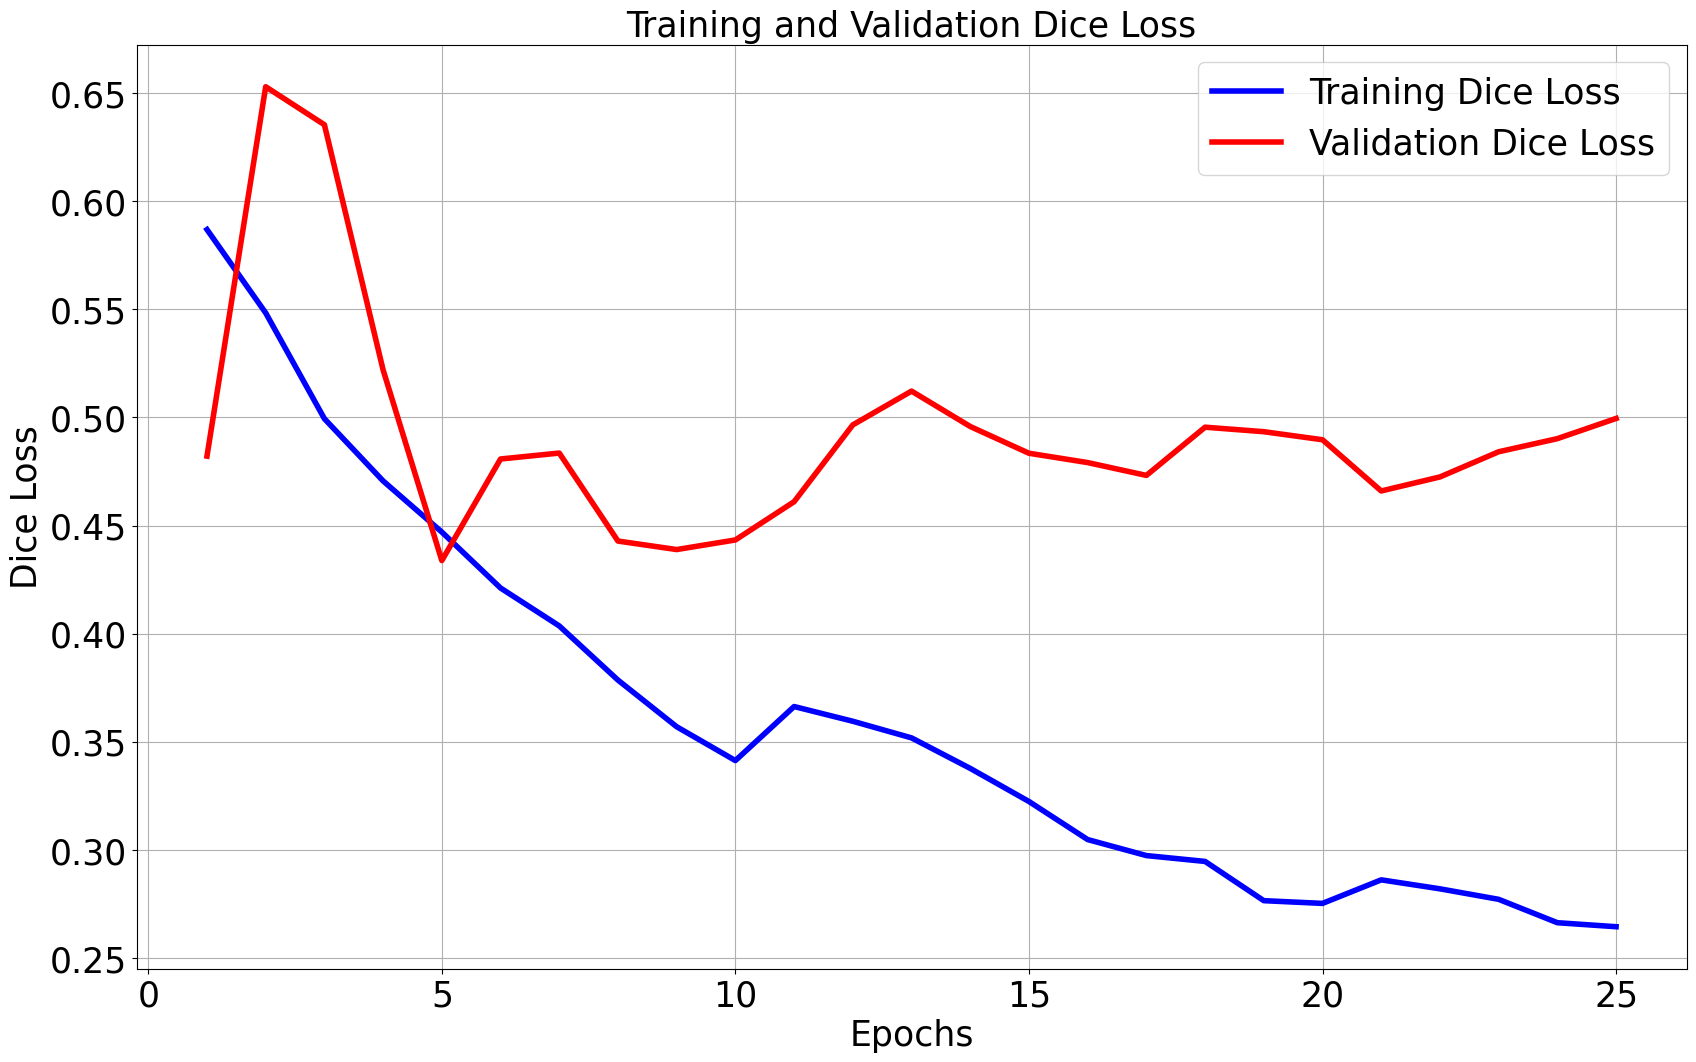

In [ ]:
plot_loss(history)

In [ ]:
def plot_iou_mean(history):
    train_loss = history.history['iou_mean']
    val_loss = history.history['val_iou_mean']
    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(20, 12))
    plt.plot(epochs, train_loss, 'b', label='Training Mean IOU', linewidth=4)
    plt.plot(epochs, val_loss, 'r', label='Validation Mean IOU', linewidth=4)
    plt.title('Training and Validation Mean IOU', fontsize=25)
    plt.xlabel('Epochs', fontsize=25)
    plt.ylabel('Mean IOU', fontsize=25)
    plt.xticks(fontsize=25)  
    plt.yticks(fontsize=25)  
    plt.legend(fontsize=25)
    plt.grid(True)
    plt.show()



    csv_filename='./miou_values.csv'
    if csv_filename:
        # Save the values to a CSV file
        with open(csv_filename, 'w', newline='') as csvfile:
            fieldnames = ['Epoch', 'Training MIOU', 'Validation MIOU']
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
            
            # Write the header
            writer.writeheader()

            # Write the values of each epoch
            for epoch, train_loss_value, val_loss_value in zip(epochs, train_loss, val_loss):
                writer.writerow({'Epoch': epoch, 'Training MIOU': train_loss_value, 'Validation MIOU': val_loss_value})



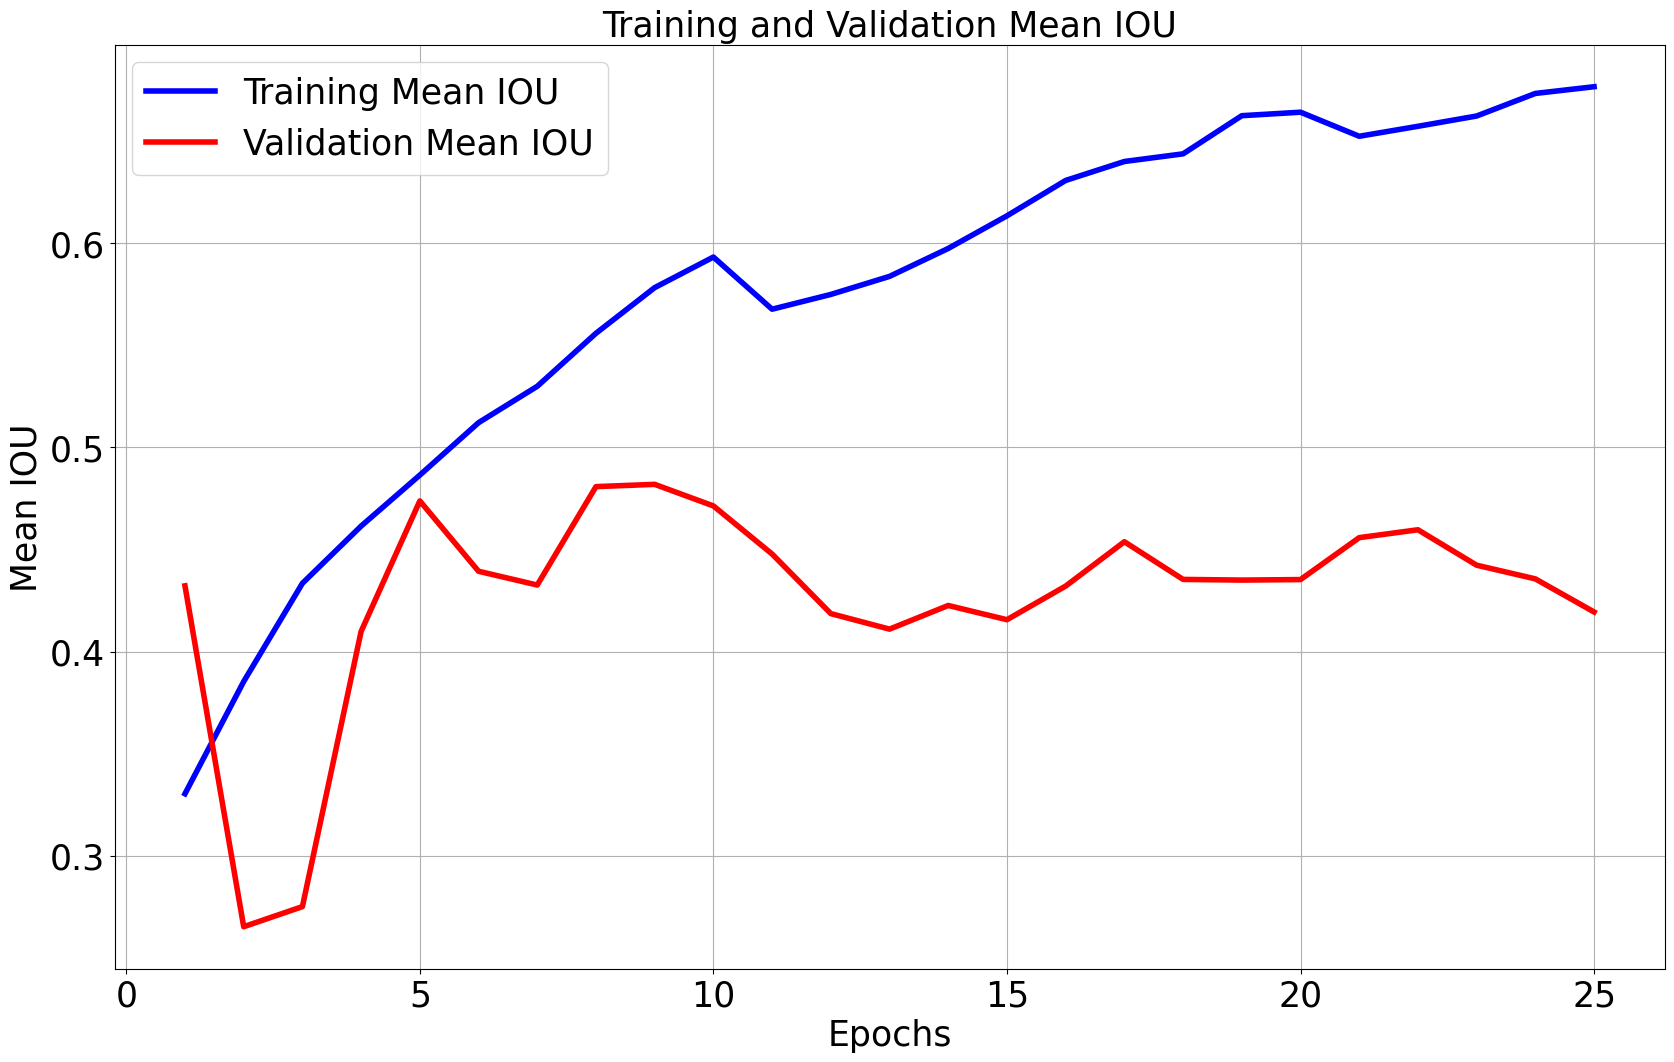

In [ ]:
plot_iou_mean(history)

In [ ]:
model.save("./restnext50.h5")